In [ ]:
import os
import shutil

if not os.path.exists('SUR_projekt2022-2023.zip'):
    !wget https://www.fit.vutbr.cz/study/courses/SUR/public/projekt_2022-2023/SUR_projekt2022-2023.zip
    !unzip SUR_projekt2022-2023.zip
if not os.path.exists('SUR_projekt2022-2023_eval.zip'):
    !wget https://www.fit.vutbr.cz/study/courses/SUR/public/projekt_2022-2023/SUR_projekt2022-2023_eval.zip
    !unzip SUR_projekt2022-2023_eval.zip


In [1]:
delete_dirs = False

if delete_dirs:
    parent_dirs = ["train", "dev"]

    for parent_dir in parent_dirs:
        for i in range(1, 32):
            current_dir = os.path.join(parent_dir, str(i))

            # Make sure the directory exists
            if os.path.exists(current_dir):
                for subdir in os.listdir(current_dir):
                    subdir_path = os.path.join(current_dir, subdir)
                    if os.path.isdir(subdir_path):
                        shutil.rmtree(subdir_path)
                        print(f"Removed directory: {subdir_path}")

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from augment import augment_images
import os
import shutil
import ikrlib as ikrl

CLASSES = 31
if not os.path.exists("results"):
    os.mkdir("results")

# Image
## CNN

In [ ]:
data_augmentation_enabled = False

# Copy all to train
for cls in range(1, CLASSES + 1):
    for f in os.listdir(os.path.join("dev", str(cls))):
       shutil.copy(os.path.join("dev", str(cls), f), os.path.join("train", str(cls), f))


if data_augmentation_enabled:
    augment_images('train', 'train/da')
    augment_images('dev', 'dev/da')

In [18]:
from image import CustomDataset, CNNModel

train_x = np.empty((0, 80, 80, 3))
train_y = np.empty(0, dtype=int)

test_x = np.empty((0, 80, 80, 3))
test_y = np.empty(0, dtype=int)

for i in range(1, CLASSES + 1):
    train_i = np.array(list(ikrl.png_load(os.path.join("train", str(i)), False).values()))
    label_i = np.full(len(train_i), i - 1)
    train_x = np.concatenate((train_x, train_i), axis=0)
    train_y = np.concatenate((train_y, label_i), axis=0)

    train_i = np.array(list(ikrl.png_load(os.path.join("dev", str(i)), False).values()))
    label_i = np.full(len(train_i), i - 1)
    train_x = np.concatenate((train_x, train_i), axis=0)
    train_y = np.concatenate((train_y, label_i), axis=0)

    test_i = np.array(list(ikrl.png_load(os.path.join("dev", str(i)), False).values()))
    label_i = np.full(len(test_i), i - 1)
    test_x = np.concatenate((test_x, test_i), axis=0)
    test_y = np.concatenate((test_y, label_i), axis=0)

print("Images were successfully loaded")

# convert 80,80,3 to 3,80,80
train_x = np.array(train_x)
train_x = np.transpose(train_x, (0, 3, 1, 2))

test_x = np.array(test_x)
test_x = np.transpose(test_x, (0, 3, 1, 2))

train_tensors = torch.Tensor(train_x)
test_tensors = torch.Tensor(test_x)

train_dataset = CustomDataset(train_tensors, train_y)
test_dataset = CustomDataset(test_tensors, test_y)
print("Dataset was successfully created")

model = CNNModel(num_classes=31, lr=1e-4)
model.train_net(train_dataset, test_dataset, num_epochs=100)
print("Model was successfully trained")


Images were successfully loaded
Dataset was successfully created
Epoch: 0/100, Loss: 91.3222, Accuracy: 0.0968, 6 and 62
Epoch: 50/100, Loss: 2.6168, Accuracy: 1.0000, 62 and 62
Epoch: 100/100, Loss: 1.0355, Accuracy: 1.0000, 62 and 62
Model was successfully trained


In [19]:
import numpy as np

data = ikrl.png_load('eval', False)
filenames = list(data.keys())
filenames = np.array([filename.replace("eval/", "") for filename in filenames])
eval_data = np.array(list(data.values()))
eval_data = np.array(eval_data)
eval_data = np.transpose(eval_data, (0, 3, 1, 2))
eval_data = torch.Tensor(eval_data)

eval_dataset = CustomDataset(eval_data, np.zeros(len(eval_data)))
pred = model.predict(eval_dataset)

pred = np.stack([tensor.detach().numpy() for tensor in pred])
exp_matrix = np.exp(pred)
row_sums = exp_matrix.sum(axis=2, keepdims=True)
cnn_predictions = exp_matrix / row_sums
cnn_predictions = np.squeeze(cnn_predictions, axis=1)
print(cnn_predictions.shape)

sorted_indices = np.argsort(filenames)
sorted_filenames = filenames[sorted_indices]
sorted_cnn_prob = np.array(cnn_predictions)[sorted_indices]

with open("results/cnn_prob_table.txt", "w") as f:
    for file, correspond_pred in zip(sorted_filenames, sorted_cnn_prob):
        pred = np.argmax(correspond_pred)
        f.write(file + ' ' + str(pred + 1) + ' ' + ' '.join(map(str, correspond_pred)) + '\n')


(736, 31)


## SVM

In [20]:
from svm import SVCTrain

model = SVCTrain()
model.train_svc(train_dataset, eval_dataset)
svm_prob = model.predict_whole_dataset(eval_data)

# Sort filenames and get the indices for sorting the matrix
sorted_indices = np.argsort(filenames)
sorted_filenames = filenames[sorted_indices]
sorted_svm_prob = np.array(svm_prob)[sorted_indices]

# Write the sorted results to a file
with open("results/svm_prob_table.txt", "w") as f:
    for file, correspond_pred in zip(sorted_filenames, sorted_svm_prob):
        pred = np.argmax(correspond_pred)
        f.write(file + ' ' + str(pred + 1) + ' ' + ' '.join(map(str, correspond_pred)) + '\n')

## GMM

Creating subs mean classes SVD
Training GMM
Iteration: 0 Total log likelihood: 18477.097340773576 for person 0
Iteration: 0 Total log likelihood: 18450.107219133504 for person 1
Iteration: 0 Total log likelihood: 18482.539252504386 for person 2
Iteration: 0 Total log likelihood: 18480.299920510948 for person 3
Iteration: 0 Total log likelihood: 18479.071529399735 for person 4
Iteration: 0 Total log likelihood: 18453.24681199388 for person 5
Iteration: 0 Total log likelihood: 18452.0911868823 for person 6
Iteration: 0 Total log likelihood: 18481.855306534057 for person 7
Iteration: 0 Total log likelihood: 18477.768308574494 for person 8
Iteration: 0 Total log likelihood: 18456.238250850492 for person 9
Iteration: 0 Total log likelihood: 18481.51888248689 for person 10
Iteration: 0 Total log likelihood: 18481.76508251923 for person 11
Iteration: 0 Total log likelihood: 18479.200591346067 for person 12
Iteration: 0 Total log likelihood: 18455.647182915098 for person 13
Iteration: 0 Total 

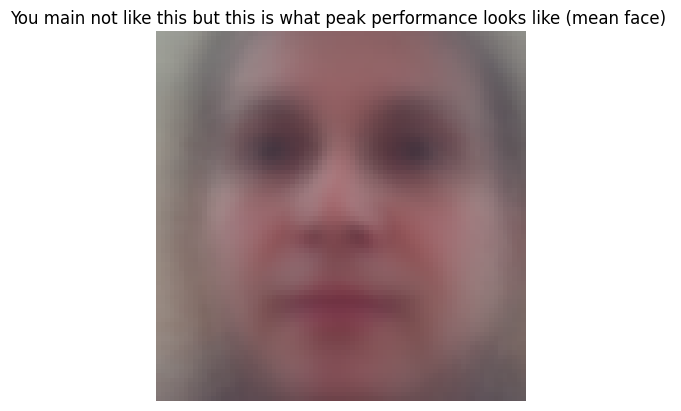

In [21]:
from gmm import GMMmodel

train_dataset_np = np.array(train_dataset.images)
train_dataset_mean_face = np.mean(train_dataset_np, axis=0)
plt.imshow(train_dataset_mean_face.transpose(1, 2, 0).astype(np.uint8))
plt.title("You main not like this but this is what peak performance looks like (mean face) ")
plt.axis('off')

model = GMMmodel()
eval_subs_mean = model.train_gmm(train_dataset, test_dataset, eval_dataset)

In [22]:
res = model.predict(eval_subs_mean[0])
res = res.T

# Subtract the maximum value from each row
res -= np.max(res, axis=1, keepdims=True)

# Calculate the exponentials
prob_matrix = np.exp(res)

# Normalize the probabilities so that they sum to 1 for each data point
gmm_image_prob = prob_matrix / prob_matrix.sum(axis=1, keepdims=True)

In [23]:
# Sort filenames and get the indices for sorting the matrix
sorted_indices = np.argsort(filenames)
sorted_filenames = filenames[sorted_indices]
sorted_gmm_image = np.array(gmm_image_prob)[sorted_indices]

# Write the sorted results to a file
with open("results/gmm_image_prob_table.txt", "w") as f:
    for file, correspond_pred in zip(sorted_filenames, sorted_gmm_image):
        pred = np.argmax(correspond_pred)
        f.write(file + ' ' + str(pred + 1) + ' ' + ' '.join(map(str, correspond_pred)) + '\n')

## Audio

In [24]:
from audio import Audio
import numpy as np

In [25]:
cepstral_mean_subtraction_enabled = False
delta_coefficients_enabled = False
coefficients_normalization = False

audio_adjust_enabled = True
reduce_noise_enabled = True
data_augmentation_enabled = True
data_pre_emphasis = False

CLASSES = 31
generate_data = False

In [26]:
audio = Audio(CLASSES, "train", "eval")
if generate_data:
    audio.do_audio_adjust(audio_adjust_enabled)
    audio.do_reduce_noise(reduce_noise_enabled)
    audio.do_data_augmentation(data_augmentation_enabled)

In [27]:
if data_pre_emphasis:
    train_audio, dev_audio = audio.do_data_pre_emphasis()
else:
    train_audio, dev_audio = audio.do_classic_load()
train_audio = audio.do_coefficients_normalization(train_audio, coefficients_normalization)
train_audio = audio.do_delta_coefficients(train_audio, delta_coefficients_enabled)
train_audio = audio.do_cepstral_mean_subtraction(train_audio, cepstral_mean_subtraction_enabled)

Processing file:  train/1/da/f401_03_f18_i0_0_stretched_aug.wav
Processing file:  train/1/da/f401_01_f18_i0_0_time_shifted_aug.wav
Processing file:  train/1/da/f401_01_f18_i0_0.wav
Processing file:  train/1/da/f401_01_r09_i0_0_stretched_aug.wav
Processing file:  train/1/da/f401_02_f18_i0_0_pitch_shifted_aug.wav
Processing file:  train/1/da/f401_04_f18_i0_0_pitch_shifted_aug.wav
Processing file:  train/1/da/f401_03_r09_i0_0_pitch_shifted_aug.wav
Processing file:  train/1/da/f401_04_f18_i0_0_stretched_aug.wav
Processing file:  train/1/da/f401_01_r09_i0_0.wav
Processing file:  train/1/da/f401_02_f18_i0_0_stretched_aug.wav
Processing file:  train/1/da/f401_03_f18_i0_0_pitch_shifted_aug.wav
Processing file:  train/1/da/f401_04_r09_i0_0_pitch_shifted_aug.wav
Processing file:  train/1/da/f401_01_r09_i0_0_time_shifted_aug.wav
Processing file:  train/1/da/f401_02_r09_i0_0_pitch_shifted_aug.wav
Processing file:  train/1/da/f401_02_r09_i0_0_stretched_aug.wav
Processing file:  train/1/da/f401_04_f

In [28]:
Ws, MUs, COVs = audio.train_gmm(train_audio, 10, 50)

Iteration: 0 Total log likelihood: -1464353.1961692118 for person 1
Iteration: 0 Total log likelihood: -1251728.6569847115 for person 2
Iteration: 0 Total log likelihood: -889092.7580932513 for person 3
Iteration: 0 Total log likelihood: -896582.011646478 for person 4
Iteration: 0 Total log likelihood: -1266856.225331546 for person 5
Iteration: 0 Total log likelihood: -938278.6151689288 for person 6
Iteration: 0 Total log likelihood: -682179.7495890605 for person 7
Iteration: 0 Total log likelihood: -857595.1715753457 for person 8
Iteration: 0 Total log likelihood: -729016.5855152479 for person 9
Iteration: 0 Total log likelihood: -1034649.7099949736 for person 10
Iteration: 0 Total log likelihood: -626232.4249982042 for person 11
Iteration: 0 Total log likelihood: -642819.6563461347 for person 12
Iteration: 0 Total log likelihood: -1848015.8678033038 for person 13
Iteration: 0 Total log likelihood: -888018.0920372234 for person 14
Iteration: 0 Total log likelihood: -893210.0867531126 

In [29]:
gmm_audio_prob, filenames = audio.eval(dev_audio, Ws, MUs, COVs, eval_format='new')

In [30]:
filenames = np.array([filename.replace("eval/rn/", "") for filename in filenames])
# Sort filenames and get the indices for sorting the matrix
sorted_indices = np.argsort(filenames)
sorted_filenames = filenames[sorted_indices]
sorted_gmm_audio_prob = np.array(gmm_audio_prob)[sorted_indices]

# Write the sorted results to a file
with open("results/gmm_audio_prob_table.txt", "w") as f:
    for file, correspond_pred in zip(sorted_filenames, sorted_gmm_audio_prob):
        pred = np.argmax(correspond_pred)
        f.write(file + ' ' + str(pred + 1) + ' ' + ' '.join(map(str, correspond_pred)) + '\n')

## Average models result

In [32]:
cnn_weight = 0.31
audio_weight = 0.24
svm_weight = 0.21
gmm_image_weight = 0.24

assert (cnn_weight + audio_weight + svm_weight + gmm_image_weight == 1)

# Multiply each model's probability matrix by its corresponding weight
weighted_gmm_audio_prob = sorted_gmm_audio_prob * audio_weight
weighted_gmm_image_prob = sorted_gmm_image * gmm_image_weight
weighted_svm_prob = sorted_svm_prob * svm_weight
weighted_cnn_prob = sorted_cnn_prob * cnn_weight

ws = weighted_gmm_audio_prob + weighted_gmm_image_prob + weighted_svm_prob + weighted_cnn_prob
average_all = ws / np.sum(ws, axis=1, keepdims=True)

cnn_weight = 0.4
audio_weight = 0.3
gmm_image_weight = 0.3

assert (cnn_weight + audio_weight + gmm_image_weight == 1)

# Multiply each model's probability matrix by its corresponding weight
weighted_gmm_audio_prob = sorted_gmm_audio_prob * audio_weight
weighted_gmm_image_prob = sorted_gmm_image * gmm_image_weight
weighted_cnn_prob = sorted_cnn_prob * cnn_weight

ws = weighted_gmm_audio_prob + weighted_gmm_image_prob + weighted_cnn_prob
average_gmm_cnn = ws / np.sum(ws, axis=1, keepdims=True)

cnn_weight = 0.6
audio_weight = 0.4

assert (cnn_weight + audio_weight == 1)

# Multiply each model's probability matrix by its corresponding weight
weighted_gmm_audio_prob = sorted_gmm_audio_prob * audio_weight
weighted_cnn_prob = sorted_cnn_prob * cnn_weight

ws = weighted_gmm_audio_prob + weighted_cnn_prob
average_gmm_audio_cnn = ws / np.sum(ws, axis=1, keepdims=True)

with open("results/average_all.txt", "w") as f:
    for file, correspond_pred in zip(sorted_filenames, average_all):
        pred = np.argmax(correspond_pred)
        f.write(file + ' ' + str(pred + 1) + ' ' + ' '.join(map(str, correspond_pred)) + '\n')

with open("results/average_gmm_cnn.txt", "w") as f:
    for file, correspond_pred in zip(sorted_filenames, average_gmm_cnn):
        pred = np.argmax(correspond_pred)
        f.write(file + ' ' + str(pred + 1) + ' ' + ' '.join(map(str, correspond_pred)) + '\n')

with open("results/average_gmm_audio_cnn.txt", "w") as f:
    for file, correspond_pred in zip(sorted_filenames, average_gmm_audio_cnn):
        pred = np.argmax(correspond_pred)
        f.write(file + ' ' + str(pred + 1) + ' ' + ' '.join(map(str, correspond_pred)) + '\n')